# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)

## Code
### *setup*

In [100]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [6]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [7]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [8]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [83]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv

In [84]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [11]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [12]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [13]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [14]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [197]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage=0.8, f_eta=None, v=True):
    if f_eta is None:
        return lambda x: x
    
    data = buildTrain(X, y, percentage)
    n_features = X.shape[1]
    n_classes = len(y.unique())
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores

In [198]:
def train_perc_cold(perc, X, y, percentage=0.8, max_iter= 5000):
    data = buildTrain(X, y, percentage)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore

In [210]:
class perc():
    def __init__(self, seed = None):
        if seed is None:
            seed = np.random.randint(66666)
        self.seed = seed
            
    def train(self, X, y, percentage=0.8, loss = 'log', penalty = 'none', alpha = 0.0001, power_t = 0.5, 
               max_iter = 5000, it_interval = 100,
               learning_rate='invscaling', eta0=1e-2):
        
        warm_start = True
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')
            
        #compute epochs
        epochs = max_iter // it_interval
            
        #create multiple perceptron
        self.perc = perc = SGDClassifier(loss=loss, penalty=penalty, max_iter=it_interval,
                             alpha=alpha, learning_rate=learning_rate, eta0=eta0,
                             warm_start=warm_start, n_jobs=-1, power_t=power_t)
        
        self.warm_start = warm_start
        param_warm = (perc, X, y, epochs, eta0, percentage, f_eta)
        param_cold = (perc, X, y, percentage, max_iter)
        
        #perform analysis
        np.random.seed(self.seed)
        if self.warm_start:
            tscores, vscores = train_perc_warm(*param_warm)
        else:
            tscores, vscores = train_perc_cold(*param_cold)
            
        #save settings
        self.param_warm = param_warm
        self.param_cold = param_cold
        
    def test(self, n=10):
        param_warm, param_cold = self.param_warm, self.param_cold
        
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(self.seed + np.random.randint(1001)*i)
            if self.warm_start:
                tscores, vscores = train_perc_warm(*param_warm, v=False)
            else:
                tscores, vscores = train_perc_cold(*param_cold)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

In [ ]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

In [ ]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

In [ ]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [216]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

my_perc = perc()

run=1 tscore=0.352909 vscore=0.358974
run=2 tscore=0.366205 vscore=0.379487
run=3 tscore=0.370083 vscore=0.379487
run=4 tscore=0.369529 vscore=0.384615
run=5 tscore=0.371745 vscore=0.384615
run=6 tscore=0.371191 vscore=0.394872
run=7 tscore=0.370083 vscore=0.394872
run=8 tscore=0.370637 vscore=0.394872
run=9 tscore=0.369529 vscore=0.384615
run=10 tscore=0.368421 vscore=0.389744


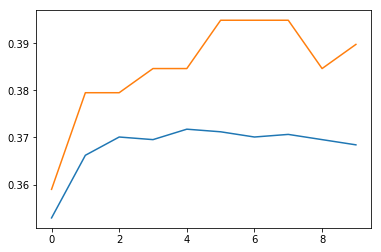

In [217]:
my_perc.train(X_std, y, percentage=0.9, loss='log', penalty='none', alpha=1e-6,
          power_t=0.5, max_iter=1000, it_interval=100, learning_rate='constant', eta0=1e-6)

average best performance: 0.37%, standard deviation: 0.031236


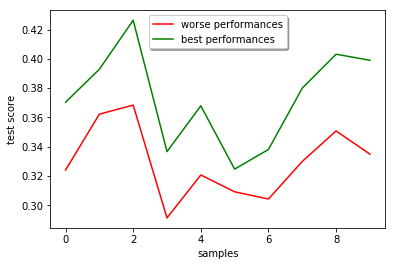

In [213]:
my_perc.test()